In [1]:
# 필요한 라이브러리 import

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 준비 (데이터는 캐글에서 불러왔음)

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68616192/68606236 [==============================] - 0s 0us/step


In [3]:
# train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
# train 데이터와 validation 데이터의 개수 확인

num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
# parameter Initialization 설정

batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
# 데이터를 시각화하기 위한 함수

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
# Training data generator (데이터가 2000장 밖에 되지 않기 때문에 Data Augmentation을 통해 데이터 수 늘림)

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [9]:
# 파이프라인을 만들어 directory와 작업 환경을 연결

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
# Data Augmentation이 제대로 되었는지 확인

train_data_gen[0][0].shape

(16, 256, 256, 3)

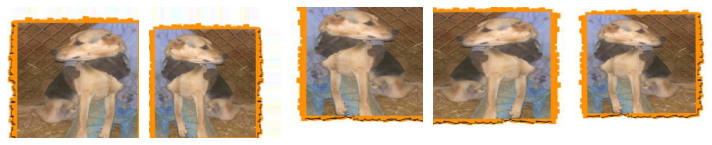

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# Validation data generator (Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경)

image_gen_val = ImageDataGenerator(rescale=1./255)

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


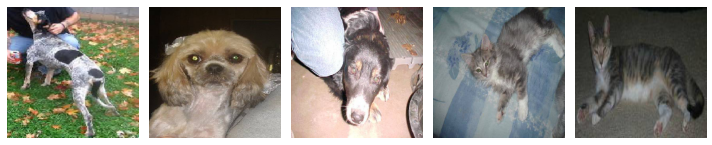

In [14]:
# Validation 데이터를 확인

sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [15]:
_[:5] # 정답 데이터

array([1., 1., 1., 0., 0.], dtype=float32)

In [16]:
# VGG16 모델을 구현  
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)

x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)

x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer = tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

In [17]:
# 손실함수, optimizer, metric을 설정

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [18]:
# 모델 학습

history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 92s 313ms/step - loss: 22497841152.0000 - binary_accuracy: 0.5000 - val_loss: 0.7343 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 38s 303ms/step - loss: 35.8269 - binary_accuracy: 0.5000 - val_loss: 0.7068 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 40s 318ms/step - loss: 0.7226 - binary_accuracy: 0.5000 - val_loss: 0.7255 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 40s 315ms/step - loss: 0.7164 - binary_accuracy: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 40s 315ms/step - loss: 0.7123 - binary_accuracy: 0.5000 - val_loss: 0.7135 - val_binary_accuracy: 0.5000


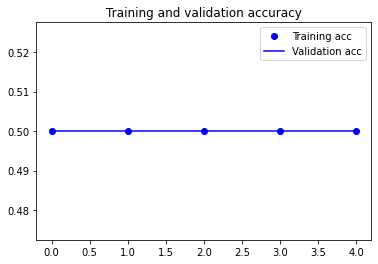

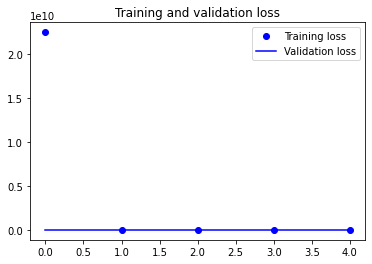

In [19]:
# 시각화를 통해 정확도 확인
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
# 문제 1-2. hyperparameter 설정
learning_rate = 2e-5
batch_size = 8
epochs = 30

In [56]:
# 문제 1-2. 모델 구현
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [67]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [63]:
print('before freeze, len of trainable_weights', len(model.trainable_weights))
base_model.trainable = False
print('after  freeze, len of trainable_weights', len(model.trainable_weights))

before freeze, len of trainable_weights 4
after  freeze, len of trainable_weights 4


In [64]:
# 문제 1-2. 데이터 generator 생성
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)
val_data_gen = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [73]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy',
              optimizer = optimize,
              metrics=['acc'])

In [74]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      validation_freq=1)

Epoch 1/30
250/250 [==============================] - 39s 155ms/step - loss: 3.0071 - acc: 0.7810 - val_loss: 0.2528 - val_acc: 0.9000
Epoch 2/30
250/250 [==============================] - 38s 152ms/step - loss: 0.2601 - acc: 0.8905 - val_loss: 0.2154 - val_acc: 0.9120
Epoch 3/30
250/250 [==============================] - 39s 155ms/step - loss: 0.2549 - acc: 0.8960 - val_loss: 0.2489 - val_acc: 0.8940
Epoch 4/30
250/250 [==============================] - 38s 152ms/step - loss: 0.2263 - acc: 0.9150 - val_loss: 0.2620 - val_acc: 0.8870
Epoch 5/30
250/250 [==============================] - 38s 152ms/step - loss: 0.2136 - acc: 0.9095 - val_loss: 0.1941 - val_acc: 0.9190
Epoch 6/30
250/250 [==============================] - 38s 153ms/step - loss: 0.2243 - acc: 0.9025 - val_loss: 0.2759 - val_acc: 0.8830
Epoch 7/30
250/250 [==============================] - 38s 152ms/step - loss: 0.1857 - acc: 0.9245 - val_loss: 0.2047 - val_acc: 0.9260
Epoch 8/30
250/250 [==============================] - 3

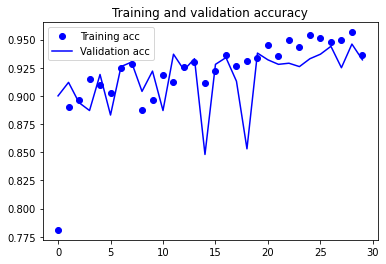

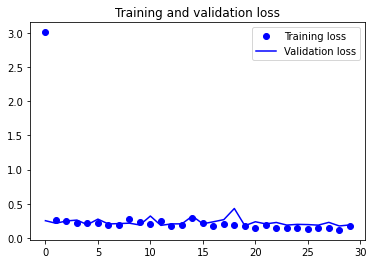

In [77]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()